### Dataset contains complaints made by citizens

https://www.scottsdaleaz.gov/news/Scottsdale_EZ_is_here_to_assist_you_s4_p26800
http://data.scottsdaleaz.gov/dataset/scottsdaleez-requests/resource/6ff8a49f-60ae-4b1c-9428-46b9e9ddd8eb

1. Can I identify times of the day, week, month of the year that are associated with specific complaints?
1. length of time complaint is open
1. relationship between complaints and weather characteristics


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
%matplotlib inline 
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'

# from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN
# from sklearn.mixture import GaussianMixture
# from sklearn.cluster import AgglomerativeClustering

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import umap
# from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### IMPORT/PREPROCESS DATA

In [21]:
df = pd.read_csv('sez_ScottsdaleEZ.csv', 
                parse_dates=['CreatedDate', 'ClosedDate'],
                error_bad_lines=False)

weather = pd.read_csv('Scottsdale_historical_weather.csv',
                     parse_dates=['DATE'],
                     index_col='DATE')

b'Skipping line 1767: expected 9 fields, saw 10\nSkipping line 3969: expected 9 fields, saw 10\nSkipping line 31357: expected 9 fields, saw 10\nSkipping line 47826: expected 9 fields, saw 10\n'


In [4]:
df.shape

(89260, 9)

In [6]:
df.dtypes

Requests           int64
Workgroup         object
RequestType       object
RequestStatus     object
Address           object
Latitude         float64
Longitude        float64
CreatedDate       object
ClosedDate        object
dtype: object

In [5]:
df.head()

,Requests,Workgroup,RequestType,RequestStatus,Address,Latitude,Longitude,CreatedDate,ClosedDate
0,260300,Water Resources,No Water,Closed,10100 N ARABIAN TR,33.578341,-111.892529,2016-08-07 07:37:38.9100000,2016-08-07 07:38:14.8570000
1,260301,Water Resources,No Water,Closed,10100 N ARABIAN TR,33.577451,-111.889969,2016-08-07 07:52:27.8470000,2016-08-07 07:52:36.1570000
2,260303,Water Resources,Meter Shut Off/On,Closed,8000 E DEL MERCURIO DR,33.567211,-111.907178,2016-08-07 10:00:36.4430000,2016-08-07 10:00:44.3800000
3,260314,Water Resources,Sewer Backup,Closed,23200 N 85TH ST,33.696606,-111.897067,2016-08-08 05:40:11.5330000,2016-08-08 05:40:25.2270000
4,260315,Water Resources,Emergency Bluestake,Closed,4900 E BUTLER DR,33.560850,-111.973250,2016-08-08 05:43:03.4270000,2016-08-08 05:43:20.1000000


In [20]:
# add datetime features
df['time_dif'] = (df.ClosedDate - df.CreatedDate).dt.days
df['month'] = df.CreatedDate.dt.month
df['day_of_week'] = df.CreatedDate.dt.day
df['hour'] = df.CreatedDate.dt.hour

In [22]:
df.dtypes

Requests                  int64
Workgroup                object
RequestType              object
RequestStatus            object
Address                  object
Latitude                float64
Longitude               float64
CreatedDate      datetime64[ns]
ClosedDate       datetime64[ns]
dtype: object

In [18]:
df['RequestType'].value_counts()

Container Repair-Residential                22929
Airport Complaint                           11515
Residential Collection Issue                 3382
Leak - General                               2949
Street Light Outage or Problem               2792
                                            ...  
Loop Recalling                                  1
Alarms                                          1
HR - General Questions                          1
AMR/AMI Related                                 1
Adopt-A-Road / Scottsdale Clean & Scenic        1
Name: RequestType, Length: 168, dtype: int64

In [94]:
# combine date and request type
requests_by_date = pd.concat([df.CreatedDate.dt.date,
        df['RequestType']], axis=1).set_index('CreatedDate')

In [95]:
requests_by_date.head()

,RequestType
CreatedDate,
2016-08-07,No Water
2016-08-07,No Water
2016-08-07,Meter Shut Off/On
2016-08-08,Sewer Backup
2016-08-08,Emergency Bluestake


In [96]:
requests_by_date = requests_by_date.groupby([requests_by_date.index, 'RequestType']).size()

In [119]:
requests_by_date.unstack()

RequestType,ADA / Accessibility Complaint Form,AMR/AMI Related,Abandoned Vehicles,Adopt-A-Road / Scottsdale Clean & Scenic,After Hours UB Turn On,Airport Complaint,Alarms,All Information Technology Request Types,Alley Surfaces,Animal Nuisance,Animals (Sanitation Issues),Appliance Collection,Aquatic/Fitness Center,Bees,Bike & Scooter Share Programs,Bird (white & black scooters),Block Party,Brown Water,Brush/Bulk Collection Issue,Bus or Transit Stop Maintenance,Citizen Contact,Clogged Street Drains,Cloudy/Colored Water,Collection Issue,Commercial Collection Issue,Conservation / Water Waste,Construction Issue,Consumer Side Problem,Container Repair-Commercial,Container Repair-Residential,Contractor Hit Line,Curb Painting Kit,DM Bulk-Brush,Damaged Sidewalks,Damaged Street Paving,Dead Animal Pick-up,Detection Issue,Directional Banner,Dispatch - Non Emergency Issue,Downtown Ambassadors,Emergency Bluestake,Facility Reservation,Fitness Center,Flooding,General Questions,Graffiti,Green Pool / Stagnant Water,HR - General Questions,Haul Route Application,High PSI,Historic Walking Tours,Home Safety visit Request,Homelessness,Household Hazardous Waste Pickup,Hydrant Leak,Hydrant Problem,Hydrant Problem SFD,Improper Barricades and Construction Hazards/Complaints,Improper Waste Disposal,Internet Outage,Irrigation/Sprinklers,Job Site Complaint / Sinkhole,Lakes,Leak - General,Leak - Meter,Leak - Street,Leisure Education,Libraries,Lime (yellow & green bikes and scooters),Loop Recalling,Low PSI,Low Pressure,Lyft scooters,Man w/Broom,Marshalling Yard,Medians/ROW,Mediation,Meter Box Hazard,Meter Shut Off/On,Meters,Michele's IT Request Type,Miscellaneous,Miscellaneous Request Types,Missing / Stolen Residential Can,Moving Boxes,Multiuse/Bike Path,Municipal Security,Neighborhood College,Neighborhood Notification,Neighborhood Watch,New Street Lights Requested,No Water,Off-Leash Dog Park,Ofo (yellow bikes),Other,Other Solid Waste Issues,Oversize / Overweight Load Permit Application,PD Off Duty Job Request,Parks,Pavement Management,Pickleball,Planning and Development Services,Pool Discharge,Potential Illegal Discharge or Containment Spill,Potholes,Preserve/Trails,Private Fire Line Verification,Programming,Property Maintenance,Rats,Residential Collection Issue,Residential Handbills,Residential Septic System Survey,Revenue Recovery,Roll-Off Container,Safety Survey,Saguaro Removal,Scottsdale Contemporary Month,Scottsdale Government 101,Senior Services,Sewer Backup,Sewer Odor,Sewer Odor Commercial,Sewer Private,Sewer Roaches,Sewer Spill,Sewers,Short-Term Rentals,Sign Problem,Sign Violations,Social Services,Soil Testing & Utility Potholing Permit Application,Spin (orange & black scooters),Sports Court,Spring Training,Stormwater Quality,Street And Shoulder Grading,Street Light Outage or Problem,Street Light Shield,Street Sweeping,Striping And Marking Problems,TMC Phone Call,Taste & Odor/Musty,Temporary Use of Public Parking Spaces,Tennis,Tool Lending Trailer,Traffic Signal Obstruction,Traffic Signal Problems,Traffic Signal Timing,Unauthorized Parking,Utility Billing - High Bill Complaint,Utility Company Annual Permit Application,Valve Cover,Violations (other),Volumetric Sewer Charge Adjustment,WQ Blue/Green Staining,WQ High Priority,WQ PH Balance Area,WQ Particles/Scaling,WQ Taste & Odor/Other,Washes,Water Issues,Water Quality (staff),Water Quality Info,Water Shut Off,Wells/Boosters,Wheels,Youth Development
CreatedDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [124]:
weather.head()

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT07,WT08
DATE,,,,,,,,,,,,,,,,,,,
2016-01-01,USW00003192,"SCOTTSDALE MUNICIPAL AIRPORT, AZ US",1.34,NaN,0.00,0.0,0.0,NaN,66.0,35.0,90.0,90.0,8.1,11.0,NaN,NaN,NaN,NaN,NaN
2016-01-02,USW00003192,"SCOTTSDALE MUNICIPAL AIRPORT, AZ US",2.01,NaN,0.00,0.0,0.0,NaN,69.0,43.0,150.0,260.0,6.9,11.0,NaN,NaN,NaN,NaN,NaN
2016-01-03,USW00003192,"SCOTTSDALE MUNICIPAL AIRPORT, AZ US",4.25,NaN,0.00,0.0,0.0,NaN,69.0,46.0,90.0,90.0,15.0,19.9,NaN,NaN,NaN,NaN,NaN
2016-01-04,USW00003192,"SCOTTSDALE MUNICIPAL AIRPORT, AZ US",6.49,NaN,0.45,0.0,0.0,NaN,65.0,51.0,120.0,110.0,16.1,23.9,NaN,NaN,NaN,NaN,NaN
2016-01-05,USW00003192,"SCOTTSDALE MUNICIPAL AIRPORT, AZ US",3.36,NaN,0.18,0.0,0.0,NaN,55.0,51.0,110.0,110.0,13.0,17.0,NaN,NaN,NaN,NaN,NaN


In [134]:
# create function that will make it easier to explore each weather feature
# and explore the relationship to request types

def corr_with_weather(weather_feature):
    req_with_weather = requests_by_date.unstack().merge(weather.loc[:, weather_feature], left_index=True, right_index=True)
    return req_with_weather.corr().mask(np.tril(np.ones(req_with_weather.corr().shape)).astype(np.bool)) \
    .loc[:, weather_feature].sort_values(ascending=False).head(15)

## The meanings behind the weather abbreviations
https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf

AWND = Average daily wind speed (meters per second or miles per hour as per user preference)
PGTM = Peak gust time (hours and minutes, i.e., HHMM)
PRCP = Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)
TMAX = Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file
TMIN = Minimum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file
WDF2 = Direction of fastest 2-minute wind (degrees)
WDF5 = Direction of fastest 5-second wind (degrees)
WSF2 = Fastest 2-minute wind speed (miles per hour or meters per second as per user preference)
WSF5 = Fastest 5-second wind speed (miles per hour or meters per second as per user preference)
WT = Weather Type where has one of the following values:
01 = Fog, ice fog, or freezing fog (may include heavy fog)
02 = Heavy fog or heaving freezing fog (not always distinguished from fog)
03 = Thunder
07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
08 = Smoke or haze

In [135]:
# precipitation correlations
corr_with_weather('PRCP')

Meter Box Hazard                     0.892099
Neighborhood Watch                   0.721469
Commercial Collection Issue          0.573964
Residential Septic System Survey     0.559969
Sports Court                         0.414537
Street Light Shield                  0.331981
Man w/Broom                          0.283863
Low Pressure                         0.238703
Job Site Complaint / Sinkhole        0.192406
Street And Shoulder Grading          0.149565
General Questions                    0.142201
Irrigation/Sprinklers                0.137284
Planning and Development Services    0.136692
Clogged Street Drains                0.131198
Sewer Odor Commercial                0.124711
Name: PRCP, dtype: float64

This surprises me, I would expect "Clogged Street Drains" to rank much more high on the list.

In [174]:
# how many Meter Box Hazard requests were there?
(df['RequestType'] == "Meter Box Hazard").sum()

40

In [136]:
# requests correlated with max temperatures

corr_with_weather('TMAX')

Temporary Use of Public Parking Spaces                 0.688729
Internet Outage                                        0.572880
Animal Nuisance                                        0.478205
Soil Testing & Utility Potholing Permit Application    0.417404
Ofo (yellow bikes)                                     0.417066
Short-Term Rentals                                     0.357157
Oversize / Overweight Load Permit Application          0.320431
Lyft scooters                                          0.301391
New Street Lights Requested                            0.285714
Spin (orange & black scooters)                         0.282102
Saguaro Removal                                        0.251681
Man w/Broom                                            0.234709
Sewer Roaches                                          0.233544
Meter Box Hazard                                       0.220033
Lime (yellow & green bikes and scooters)               0.206488
Name: TMAX, dtype: float64

In [168]:
# requests correlated with high winds

corr_with_weather('WDF5')

Internet Outage                              0.583041
Residential Handbills                        0.474166
Neighborhood Watch                           0.416974
Leisure Education                            0.361499
Temporary Use of Public Parking Spaces       0.348128
Historic Walking Tours                       0.282572
WQ PH Balance Area                           0.280135
Residential Septic System Survey             0.253491
Libraries                                    0.233675
Off-Leash Dog Park                           0.210897
Sewer Odor Commercial                        0.187582
Utility Company Annual Permit Application    0.174323
Other Solid Waste Issues                     0.169309
Short-Term Rentals                           0.164024
Miscellaneous Request Types                  0.151902
Name: WDF5, dtype: float64

Internet outage could be caused by broken tree branches falling on wires.

## Examine weather types as it relates to frequency of specific requests.  For each request, find the count during a weather event and in the absence of the weather event and examine which requests are more frequently associated with the weather event.

- WT** = Weather Type where ** has one of the following values: 
 - 01 = Fog, ice fog, or freezing fog (may include heavy fog)
 - 02 = Heavy fog or heaving freezing fog (not always distinguished from fog)
 - 03 = Thunder
 - 07 = Dust, volcanic ash, blowing dust, blowing sand, or blowing obstruction
 - 08 = Smoke or haze

In [145]:
# change bool format of weather type column
for column in weather.loc[:,'WT01':]:
    weather[column] = weather[column].notnull()

In [155]:
# add date as index
df.set_index(df.CreatedDate.dt.date, inplace=True)

In [159]:
# create function to examine weather types more easily

def corr_with_weather_type(weather_feature):
    return (df.merge(weather, left_index=True, right_index=True).groupby(['RequestType', weather_feature]).size().unstack().iloc[:, 1] -
    df.merge(weather, left_index=True, right_index=True).groupby(['RequestType', weather_feature]).size().unstack().iloc[:, 0])    .sort_values(ascending=False).head(20)

In [160]:
# for fog weather, compare count 
# on days with vs. without that weather feature
corr_with_weather_type('WT01')

RequestType
Residential Septic System Survey                 166.0
Commercial Collection Issue                       21.0
Construction Issue                                 1.0
Water Quality (staff)                             -1.0
Ofo (yellow bikes)                                -3.0
Stormwater Quality                                -4.0
Flooding                                          -5.0
Scottsdale Contemporary Month                     -5.0
Sewer Private                                     -6.0
Lakes                                             -6.0
Saguaro Removal                                   -6.0
Wells/Boosters                                    -7.0
Leisure Education                                 -9.0
Roll-Off Container                                -9.0
Oversize / Overweight Load Permit Application    -10.0
Libraries                                        -10.0
Sewer Spill                                      -10.0
Traffic Signal Obstruction                       -10.

Residential Septic System Survey  has by far the most requests on foggy days.  I don't see the connection here.  I would expect flooding to be much higher on the ranking.

In [161]:
# for thunder weather, compare count 
# on days with vs. without that weather feature

corr_with_weather_type('WT03')

RequestType
Mediation                                   0.0
Marshalling Yard                            0.0
Fitness Center                             -1.0
Youth Development                          -1.0
ADA / Accessibility Complaint Form         -1.0
WQ Blue/Green Staining                     -2.0
Private Fire Line Verification             -2.0
Scottsdale Contemporary Month              -3.0
Downtown Ambassadors                       -3.0
Construction Issue                         -3.0
Traffic Signal Obstruction                 -4.0
Saguaro Removal                            -4.0
Lakes                                      -4.0
Stormwater Quality                         -4.0
Flooding                                   -5.0
All Information Technology Request Types   -5.0
Residential Handbills                      -6.0
Sewer Private                              -6.0
Sewer Spill                                -8.0
Roll-Off Container                         -9.0
dtype: float64

In [162]:
# for smoke or haze weather, compare count 
# on days with vs. without that weather feature

corr_with_weather_type('WT08')

RequestType
Private Fire Line Verification     0.0
Water Quality (staff)             -3.0
Ofo (yellow bikes)                -3.0
Construction Issue                -3.0
WQ Blue/Green Staining            -4.0
Flooding                          -5.0
New Street Lights Requested       -6.0
Lakes                             -6.0
Facility Reservation              -6.0
Stormwater Quality                -6.0
Commercial Collection Issue       -7.0
Leisure Education                 -7.0
Scottsdale Contemporary Month     -7.0
Saguaro Removal                   -8.0
Senior Services                   -8.0
Directional Banner               -10.0
Sewer Spill                      -10.0
Animals (Sanitation Issues)      -10.0
Traffic Signal Obstruction       -10.0
Revenue Recovery                 -12.0
dtype: float64

### Plot Requests Over Time

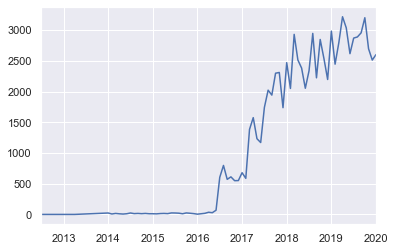

In [204]:
# what is the trend of people submitting requests?
# it seems that spikes are occuring at regular intervals

df.CreatedDate.dt.to_period('M').value_counts().sort_index().plot()

In [210]:
# find top 10 request
df['RequestType'].value_counts().head(10).index

Index(['Container Repair-Residential', 'Airport Complaint',
       'Residential Collection Issue', 'Leak - General',
       'Street Light Outage or Problem', 'Household Hazardous Waste Pickup',
       'Collection Issue', 'Leak - Meter', 'Moving Boxes', 'DM Bulk-Brush'],
      dtype='object')

In [215]:
top_ten_requests = df[df['RequestType'].isin(df['RequestType'].value_counts().head(10).index)]

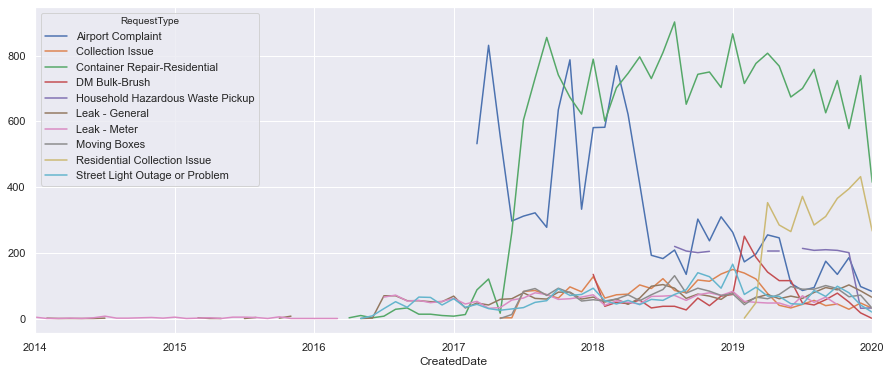

In [233]:
# plot only the top 10 requests
top_ten_requests.groupby([top_ten_requests.CreatedDate.dt.to_period('M'), 'RequestType']).size().unstack().plot(figsize=(15, 6));

It's interesting how airport noise has diminished substantially since mid-2018 when I still see articles in the newspaper about people being annoyed with aircraft sound.